Baseline Q-learning before inverse reinforcement learning

In [1]:
import gym
%pylab inline
import pylab
import numpy as np

# To get smooth animations
%matplotlib inline
import matplotlib as mpl
mpl.rc('animation', html='jshtml')
import matplotlib.animation as animation

Populating the interactive namespace from numpy and matplotlib


In [14]:
# Initialize environment and reset it to start at valley with 0 velocity
env = gym.make('MountainCar-v0')

'''
To descretize the state space, we separate the range of possible continuous positions x and
continuous velocities v into 20 bins (one_feature)
'''
print('Action space: ', env.action_space)
n_actions = env.action_space.n

n_feature_bins = 20 # number of state per one feature

env_low = env.observation_space.low     
env_high = env.observation_space.high   
env_distance = (env_high - env_low) / n_feature_bins 

print(env_low, env_high, env_distance, env_distance[0]*20, env_distance[1]*20)
# the range of x is 1.8 and velocity is 0.14 

n_states = n_feature_bins*n_feature_bins # states are the space of combinations of x and v


#load the expert 20 demonstrations
expert_demo = np.load('Data/expert_demo.npy')
print(expert_demo.shape)

# (number of demonstrations, length of demonstrations, states and actions of demonstrations)
print(expert_demo[0,60,:], expert_demo[0,0,:].shape)

# as you can see from step 60 of the first example, the best strategy is to first accelerate backwards into
# the < -0.8 range into order to gain speed going right into the valley.


'''
using this bin size we descretize the expert demonstrations
The difference between expert_demo and demonstrations is that
demonstrations consists of discreet integers instead of continuous values
for it's states



here I used n for sample index and t for timestep index
'''
def idx_state(state):
    '''
    this function converts a continuous state vector of
    2-dim into a discrete index
    
    by assigning each state and index of state_idx = position_idx + velocity_idx * one_feature
    we make sure that (position_idx, velocity_idx) = (2,3) and (3,2) map to different integers
    The first 20 elements of state_idx go to position_idx = 0 - 19, velocity_idx = 0, etc
    '''
    position_idx = int((state[0] - env_low[0]) / env_distance[0])
    velocity_idx = int((state[1] - env_low[1]) / env_distance[1])
    state_idx = position_idx + velocity_idx * n_feature_bins
    return state_idx

demonstrations = np.zeros((len(expert_demo), len(expert_demo[0]), 3))

for n in range(len(expert_demo)):
    
    for t in range(len(expert_demo[0])):

        state_idx = idx_state(expert_demo[n][t])

        demonstrations[n][t][0] = state_idx
        demonstrations[n][t][1] = expert_demo[n][t][2]

Action space:  Discrete(3)
[-1.2  -0.07] [0.6  0.07] [0.09  0.007] 1.8000000715255737 0.14000000432133675
(20, 130, 3)
[-0.90691623 -0.02983074  0.        ] (3,)


In [15]:
def update_q_table(state, action, reward, q_learning_rate, gamma, next_state):
    ''' 
    The Q-learning update rule
    𝑄(𝑠,𝑎)←𝑄(𝑠,𝑎)+𝛼(𝑟+𝛾*max_𝑎′𝑄(𝑠′,𝑎′)−𝑄(𝑠,𝑎))
    𝛾 or gamma, is the discount factor
    𝛼 or alpha, is the q_learning_rate
    '''
    q_1 = q_table[state][action]
    #print(reward, gamma, max(q_table[next_state])) 
    q_2 = reward + gamma * max(q_table[next_state])
    q_table[state][action] += q_learning_rate * (q_2 - q_1)

0 episode score is -200.00
1000 episode score is -200.00
2000 episode score is -200.00
3000 episode score is -200.00
4000 episode score is -200.00
5000 episode score is -200.00
6000 episode score is -200.00
7000 episode score is -200.00
8000 episode score is -200.00
9000 episode score is -199.38
saving new best
10000 episode score is -199.95
11000 episode score is -198.56
saving new best
12000 episode score is -198.45
saving new best
13000 episode score is -195.89
saving new best
14000 episode score is -196.84
15000 episode score is -194.93
saving new best
16000 episode score is -177.39
saving new best
17000 episode score is -185.35
18000 episode score is -180.66
19000 episode score is -194.98
20000 episode score is -172.53
saving new best
21000 episode score is -176.83
22000 episode score is -156.96
saving new best
23000 episode score is -150.14
saving new best
24000 episode score is -156.41
25000 episode score is -167.52
26000 episode score is -152.74
27000 episode score is -147.82
s

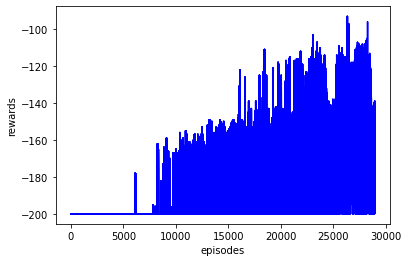

In [20]:
np.random.seed(42)
n_episodes = 30000
epsilon, min_eps = 0.8, 0
# Calculate episodic reduction in epsilon
reduction = (epsilon - min_eps)/n_episodes
q_learning_rate = 0.03
gamma = 0.99
q_table = np.zeros((n_states, n_actions)) # (400, 3)
episodes = []
scores = []
best_score = -200

for episode in range(n_episodes):
    
    state = env.reset()
    score = 0
    
    # For each episode, run the simulation until the 200 step time limit or success
    while True:
        
        state_idx = idx_state(state)
        
        # Determine next action - epsilon greedy strategy
        if np.random.random() < epsilon:
            action = np.random.randint(0, env.action_space.n)
        else:
            # this is the greedy option
            action = np.argmax(q_table[state_idx]) 
            # get the best column, action, from the Q-table
            
        next_state, reward, done, _ = env.step(action) # take action, get new state
        # Discretize next_state
        next_state_idx = idx_state(next_state) 
        
        # update the Q-table using the Q-learning update rule and the approximated reward 
        update_q_table(state_idx, action, reward, q_learning_rate, gamma, next_state_idx)
        
        score += reward
        state = next_state
        
        if done:
            scores.append(score)
            episodes.append(episode)
            break
            
    # Decay epsilon
    if epsilon > min_eps:
        epsilon -= reduction
        
    if episode % 1000 == 0:
        
        score_avg = np.mean(scores[-100:])
        print('{} episode score is {:.2f}'.format(episode, score_avg))
        if score_avg > -110:
            print('solved!')
            break
            
        pylab.plot(episodes, scores, 'b')
        pylab.xlabel('episodes')
        pylab.ylabel('rewards')
        pylab.savefig("Data/qlearn_30000.png")
        
        if score_avg > best_score:
            best_score = score_avg
            print('saving new best')
            np.save("Data/qlearn_q_table", arr=q_table)

In [21]:
def render_policy_net(q_table, n_max_steps=200, seed=42):
    frames = []
    env = gym.make('MountainCar-v0')
    env.seed(seed)
    np.random.seed(seed)
    state = env.reset()
    score = 0
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        
        state_idx = idx_state(state)
        action = np.argmax(q_table[state_idx])
        
        state, reward, done, info = env.step(action)
        score += reward
        
        if done:
            break
            
    env.close()
    print('score',score)
    return frames

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [22]:
q_table = np.load("Data/maxent_q_table.npy")
frames = render_policy_net(q_table)
plot_animation(frames)

score -141.0
